In [1]:
import pandas as pd # data frame manipulation
import numpy as np # data frame operations
from scipy import stats # importing scipy
from scipy.stats import chi2 
from scipy.stats import *
import matplotlib.pyplot as plt # importing matplotlib module 
import matplotlib
import seaborn as sns
#set figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 5]
#igonre warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

# Data preprocessing
## Retrieving data

In [2]:
# Importing all three CSV datafiles
airport_codes = pd.read_csv('Airport_Codes.csv')
tickets = pd.read_csv('Tickets.csv')
flights = pd.read_csv('Flights.csv')

In [3]:
# Filtering medium and large airports; seperating the cancelled flights
airport_codes = airport_codes[((airport_codes['TYPE'] == 'medium_airport') | (airport_codes['TYPE'] == 'large_airport')) 
                              & (airport_codes['ISO_COUNTRY'] == 'US')]
tickets = tickets[tickets['ROUNDTRIP'] == 1]
flights = flights[flights['CANCELLED'] == 0]

## Eliminating duplicate records from all three files

In [4]:
print (len(airport_codes))
print (len(airport_codes.drop_duplicates()))
airport_codes = airport_codes.drop_duplicates()

print (len(flights))
print (len(flights) - len(flights.drop_duplicates()))
flights = flights.drop_duplicates()

print (len(tickets))
print (len(tickets) - len(tickets.drop_duplicates()))
tickets = tickets.drop_duplicates()

858
858
1864272
4410
708600
47564


## Drop non-required columns from all three data files

In [5]:
airport_codes = airport_codes.drop(['NAME','CONTINENT','ISO_COUNTRY','MUNICIPALITY','COORDINATES','ELEVATION_FT'], axis = 1)
print(airport_codes.info()) # Display updated records for each file

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 6194 to 50008
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TYPE       858 non-null    object
 1   IATA_CODE  821 non-null    object
dtypes: object(2)
memory usage: 20.1+ KB
None


In [6]:
tickets = tickets.drop(['ITIN_ID','YEAR','QUARTER','ORIGIN_COUNTRY','ORIGIN_STATE_ABR','ROUNDTRIP'], axis = 1)
print(tickets.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661036 entries, 0 to 1115067
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ORIGIN             661036 non-null  object 
 1   ORIGIN_STATE_NM    661036 non-null  object 
 2   REPORTING_CARRIER  661036 non-null  object 
 3   PASSENGERS         660076 non-null  float64
 4   ITIN_FARE          660585 non-null  object 
 5   DESTINATION        661036 non-null  object 
dtypes: float64(1), object(5)
memory usage: 35.3+ MB
None


In [7]:
flights = flights.drop(['FL_DATE','OP_CARRIER_FL_NUM','TAIL_NUM','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID'], axis = 1)
print(flights.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859862 entries, 0 to 1911340
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   OP_CARRIER        object 
 1   ORIGIN            object 
 2   ORIGIN_CITY_NAME  object 
 3   DESTINATION       object 
 4   DEST_CITY_NAME    object 
 5   DEP_DELAY         float64
 6   ARR_DELAY         float64
 7   CANCELLED         float64
 8   AIR_TIME          object 
 9   DISTANCE          object 
 10  OCCUPANCY_RATE    float64
dtypes: float64(4), object(7)
memory usage: 170.3+ MB
None


### Fixing columns with inconsistance values

In [8]:
# Removing the '$' sign from fare values
tickets = tickets.assign(ITIN_FARE = lambda x: x['ITIN_FARE'].str.extract('(\d+)'))

In [9]:
# Replacing the non-numerical values with Null from 'air_time' and 'distance' columns
flights = flights.assign(AIR_TIME = lambda x: x['AIR_TIME'].str.extract('(\d+)'))
flights = flights.assign(DISTANCE = lambda x: x['DISTANCE'].str.extract('(\d+)'))

In [10]:
# Type casting 'object' to 'float' for ITIN_FARE, AIR_TIME, and DISTANCE
tickets['ITIN_FARE'] = tickets['ITIN_FARE'].astype(float)
flights['AIR_TIME'] = flights['AIR_TIME'].astype(float)
flights['DISTANCE'] = flights['DISTANCE'].astype(float)

In [11]:
# Remove negative entries from departure and arrival delay values of flights

# When substraction result is negative then replace with zero value
flights['DEP_DELAY'].loc[flights['DEP_DELAY']<0] = 0
flights['ARR_DELAY'].loc[flights['ARR_DELAY']<0] = 0
# Removing the fifteen minutes time as delay consideration (as per requirement)
flights['DEP_DELAY'] = np.where((flights['DEP_DELAY'] - 15 < 0), 0, flights['DEP_DELAY'] - 15)
flights['ARR_DELAY'] = np.where((flights['ARR_DELAY'] - 15 < 0), 0, flights['ARR_DELAY'] - 15)

In [12]:
# Considering occupancy rate of flights is 200 (as per requirement)
flights['OCCUPANCY_RATE'] = flights["OCCUPANCY_RATE"] * 200

### Outliers identification for Flights and Tickets data

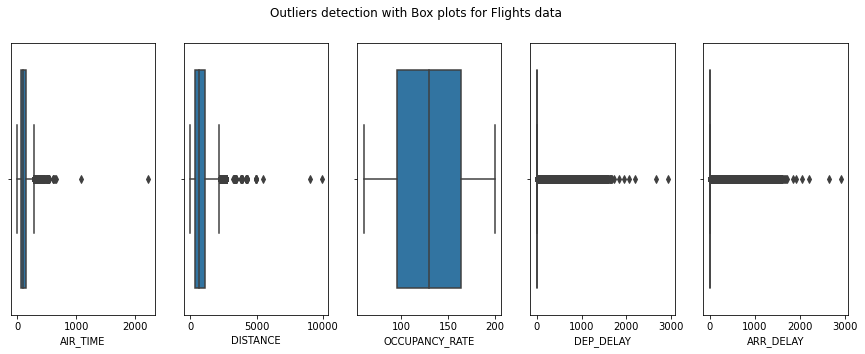

In [13]:
# Outliers visualization using Box plots for flights df
figure, ax = plt.subplots(1, 5)
sns.boxplot(x = 'AIR_TIME', data = flights, ax = ax[0])
sns.boxplot(x = 'DISTANCE', data = flights, ax = ax[1])
sns.boxplot(x = 'OCCUPANCY_RATE', data = flights, ax = ax[2])
sns.boxplot(x = 'DEP_DELAY', data = flights, ax = ax[3])
sns.boxplot(x = 'ARR_DELAY', data = flights, ax = ax[4])
figure.suptitle('Outliers detection with Box plots for Flights data') # Plot title

figure.show() # function to show the plot

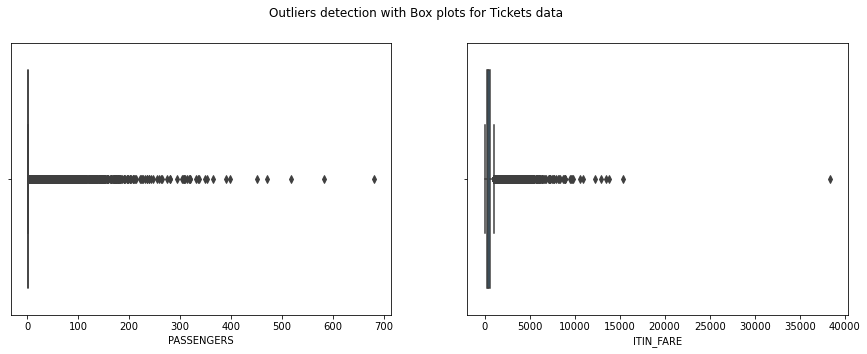

In [14]:
# Outliers visualization using Box plots for Tickets data
figure, ax = plt.subplots(1, 2)
sns.boxplot(x = 'PASSENGERS', data = tickets, ax = ax[0])
sns.boxplot(x = 'ITIN_FARE', data = tickets, ax = ax[1])
figure.suptitle('Outliers detection with Box plots for Tickets data') # Plot title

figure.show() # function to show the plot

### Data anomalies of fair price

In [15]:
# An instance of anomalies in tickets data
# Unrealistic high price of air fare
tickets[tickets['ITIN_FARE'] > 13000]

,ORIGIN,ORIGIN_STATE_NM,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
36135,PIH,Idaho,OO,1.00,13790.00,SLC
927914,SFO,California,UA,1.00,13474.00,LAS
929787,SFO,California,UA,1.00,15365.00,EWR
968736,SLC,Utah,OO,1.00,38400.00,TWF


[Text(0, 0, 'Utah'), Text(1, 0, 'California'), Text(2, 0, 'Idaho')]

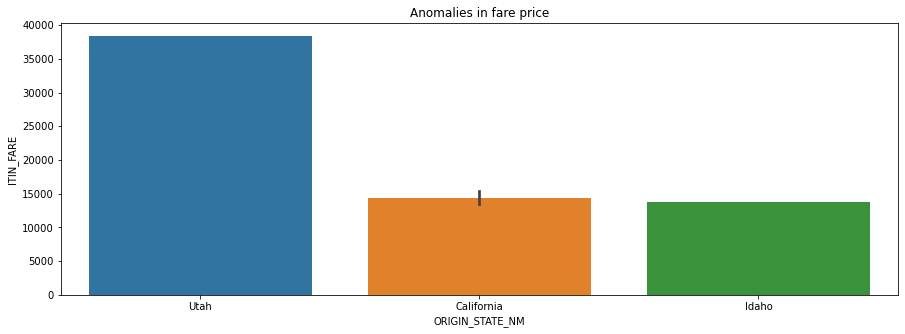

In [16]:
tmp = tickets.sort_values(by = 'ITIN_FARE', ascending = False)[:4]

# Visualizing by using Seaborn bar plot of orig state & fare
plt.title('Anomalies in fare price')
ax = sns.barplot(x = tmp['ORIGIN_STATE_NM'], y = tmp['ITIN_FARE'])
ax.set_xticklabels(ax.get_xticklabels())

In [17]:
# Unrealistic very low fare rate
tickets[tickets['PASSENGERS'] > 400]

,ORIGIN,ORIGIN_STATE_NM,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
333958,DTW,Michigan,DL,681.00,11.00,MCO
336742,DTW,Michigan,DL,471.00,11.00,TPA
356723,EWR,New Jersey,UA,519.00,0.00,PBI
611214,MDW,Illinois,WN,582.00,11.00,MCO
786267,PHX,Arizona,WN,451.00,11.00,LAS


### Handling outliers

In [18]:
# 1 .replacing the outliers with median value
def replaceWithMedian(df, col, value_min = False, value_max = False):
    if(value_max):
        df[col].loc[df[col] > value_max] = df[col].median()
    if(value_max):
        df[col].loc[df[col] < value_min] = df[col].median()
    else:
        raise ValueError('None of from minimum and maximum values passed. Atleast one should!')
    

In [19]:
# 2.a. removing very high values from 'Passengers', 'Itin_Fare' of Tickets data
replaceWithMedian(tickets,'PASSENGERS', 0, 400)
replaceWithMedian(tickets,'ITIN_FARE', 20, 13000)

In [20]:
# 2.b. removing very high values from 'Dep_Delay', 'Arr_Delay', 'Air_Time', 'Distance' of Flights data
replaceWithMedian(flights,'DEP_DELAY', False, 1750)
replaceWithMedian(flights,'ARR_DELAY', False, 2000)
replaceWithMedian(flights,'AIR_TIME', 50, 1000)
replaceWithMedian(flights,'DISTANCE', 50, 6000)

### Null values issue

In [21]:
# Remove missing rows of airport codes. Passenger and fare column from flights and arrival delay, air time, distance, occupancy rate columns 
# from flights data, contains null values which will be replaced with median
print (airport_codes.isnull().sum() * 100 / len(airport_codes))
print (tickets.isnull().sum() * 100 / len(tickets))
print (flights.isnull().sum() * 100 / len(flights))

TYPE        0.00
IATA_CODE   4.31
dtype: float64
ORIGIN              0.00
ORIGIN_STATE_NM     0.00
REPORTING_CARRIER   0.00
PASSENGERS          0.15
ITIN_FARE           0.07
DESTINATION         0.00
dtype: float64
OP_CARRIER          0.00
ORIGIN              0.00
ORIGIN_CITY_NAME    0.00
DESTINATION         0.00
DEST_CITY_NAME      0.00
DEP_DELAY           0.00
ARR_DELAY           0.23
CANCELLED           0.00
AIR_TIME           99.45
DISTANCE           99.45
OCCUPANCY_RATE      0.00
dtype: float64


In [22]:
# replace null values with median values for all three data files
airport_codes = airport_codes.fillna(airport_codes.median())
tickets = tickets.fillna(tickets.median())
flights = flights.fillna(flights.median())

In [23]:
# removing rows with missing IATA_CODE from airport_codes file; rows with passengers and itin fare missing values from tickets file; 
# and replace arrival delay, arrival time, distance, and occupancy rate with median values
print (airport_codes.isnull().sum())
print (tickets.isnull().sum())
print (flights.isnull().sum())

TYPE          0
IATA_CODE    37
dtype: int64
ORIGIN               0
ORIGIN_STATE_NM      0
REPORTING_CARRIER    0
PASSENGERS           0
ITIN_FARE            0
DESTINATION          0
dtype: int64
OP_CARRIER          0
ORIGIN              0
ORIGIN_CITY_NAME    0
DESTINATION         0
DEST_CITY_NAME      0
DEP_DELAY           0
ARR_DELAY           0
CANCELLED           0
AIR_TIME            0
DISTANCE            0
OCCUPANCY_RATE      0
dtype: int64


## Combine all files

In [24]:
# Using groupby, combin tickets, and flights data based on ORIGIN and DESTINATION common columns
tickets = tickets.groupby(['ORIGIN','DESTINATION']).agg({'ORIGIN_STATE_NM':'first',
                                                   'PASSENGERS': np.sum,
                                                   'ITIN_FARE': np.sum}).reset_index()

flights = flights.groupby(['ORIGIN','DESTINATION']).agg({'ORIGIN_CITY_NAME':'first',
                                                                        'DEST_CITY_NAME': 'first',
                                                                        'DEP_DELAY': np.sum,
                                                                        'ARR_DELAY': np.sum,
                                                                        'AIR_TIME': np.sum,
                                                                        'DISTANCE': np.sum,
                                                                        'OCCUPANCY_RATE':np.sum,
                                                                        'CANCELLED':'count'}).reset_index() # for total count of flight which are on route

In [25]:
# combining all dataframes to get final table
combined = tickets.merge(flights,on = ['ORIGIN','DESTINATION'])
combined = combined.merge(airport_codes, left_on = 'ORIGIN', right_on = 'IATA_CODE', suffixes = ('_left', '_right'))
combined = combined.merge(airport_codes, left_on = 'DESTINATION', right_on = 'IATA_CODE', suffixes = ('_left', '_right'))
combined.drop(columns = {'IATA_CODE_left','IATA_CODE_right'}, inplace = True)
combined.rename(columns = {'CANCELLED':'total_count'}, inplace = True)
combined['route'] = combined['ORIGIN_CITY_NAME'] + ' TO ' + combined['DEST_CITY_NAME']
df = combined.copy()

# Solutions

## 1. Ten busiest round trips in terms of round trip counts in the quarter (cancelled flights are excluded):

[Text(0, 0, 'San Francisco, CA TO Los Angeles, CA'),
 Text(1, 0, 'Los Angeles, CA TO San Francisco, CA'),
 Text(2, 0, 'Chicago, IL TO New York, NY'),
 Text(3, 0, 'New York, NY TO Chicago, IL'),
 Text(4, 0, 'Los Angeles, CA TO Las Vegas, NV'),
 Text(5, 0, 'Las Vegas, NV TO Los Angeles, CA'),
 Text(6, 0, 'Los Angeles, CA TO New York, NY'),
 Text(7, 0, 'New York, NY TO Los Angeles, CA'),
 Text(8, 0, 'Los Angeles, CA TO Seattle, WA'),
 Text(9, 0, 'Seattle, WA TO Los Angeles, CA')]

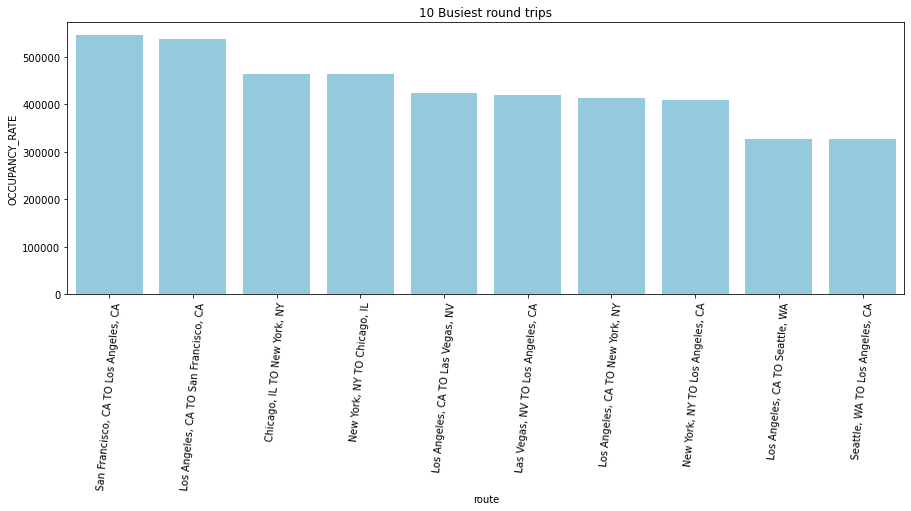

In [26]:
# Sorting 10 trips in desending order
tmp = df.sort_values(by = 'OCCUPANCY_RATE', ascending = False)[:10]

# Visualizing by using Seaborn bar plot of route vs. occupancy rate
plt.title('10 Busiest round trips')
ax = sns.barplot(x = tmp['route'], y = tmp['OCCUPANCY_RATE'], color='skyblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 85)

## 2. The 10 most profitable round trip routes:

### Calculations based upon given assumptions

In [27]:
df = df[['route','PASSENGERS','ITIN_FARE','DEP_DELAY','ARR_DELAY','DISTANCE','OCCUPANCY_RATE','total_count','TYPE_left','TYPE_right']]

# Formula for total fare is equal to PASSENGERS * ITIN_FARE
df['total_fare'] = df['PASSENGERS'] * df['ITIN_FARE']

# As per assumptions provided for baggage fee the formula for baggage income is equal to OCCUPANCY_RATE * 70 * 0.5
df['baggage_cost'] = df['OCCUPANCY_RATE'] * 70 * 0.5

# The arrival and Departure Delay cost is equal to Arrival delay * 75 + Departure delay * 75
df['arr_delay_cost'] = df['ARR_DELAY'] * 75
df['dep_delay_cost'] = df['DEP_DELAY'] * 75

# Airport cost is 5000 dollars for medium airports and 10,000 dollars for large airports
# Airport cost equals to sum of medium and large
df['airport_cost'] = np.where((df['TYPE_left'] == 'medium_airport'), df['total_count'] * 5000, df['total_count'] * 10000)
df['airport_cost'] = np.where((df['TYPE_right'] == 'medium_airport'), df['airport_cost'] + df['total_count'] * 5000, df['airport_cost'] + df['total_count'] * 10000)

# All basic costs include Fuel, Oil, Maintenance, Crew; total Depreciation, Insurance, Other is sum of $8 and $1.18 per miles
df['basics_cost'] = df['DISTANCE'] * 9.18

# Formula for Total Profit = (Fare charges + Baggage Income) – (Basic cost + Arrival & Departure Delay cost + Airport cost)
df['income'] = df['total_fare'] + df['baggage_cost']
df['cost'] = df['arr_delay_cost'] + df['dep_delay_cost'] + df['airport_cost'] + df['basics_cost']

[Text(0, 0, 'New York, NY TO Los Angeles, CA'),
 Text(1, 0, 'Los Angeles, CA TO New York, NY'),
 Text(2, 0, 'New York, NY TO San Francisco, CA'),
 Text(3, 0, 'Newark, NJ TO San Francisco, CA'),
 Text(4, 0, 'Minneapolis, MN TO Fort Myers, FL'),
 Text(5, 0, 'Minneapolis, MN TO Phoenix, AZ'),
 Text(6, 0, 'Newark, NJ TO Orlando, FL'),
 Text(7, 0, 'Chicago, IL TO Los Angeles, CA'),
 Text(8, 0, 'Newark, NJ TO Los Angeles, CA'),
 Text(9, 0, 'Los Angeles, CA TO Honolulu, HI')]

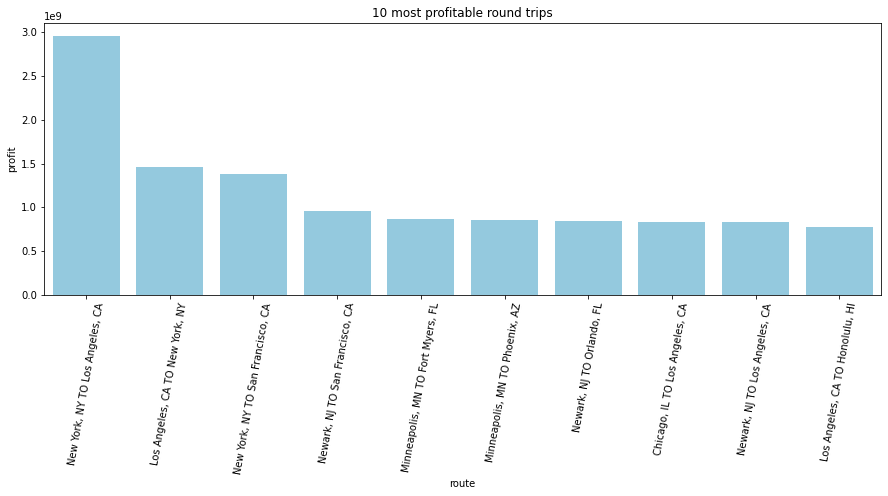

In [28]:
# Visualization of total profit with Seaborn bar plots
df['profit'] = df['income']- df['cost']
tmp = df.sort_values(by = 'profit',ascending = False)[:10]
plt.title('10 most profitable round trips')
ax = sns.barplot(x = tmp['route'],y = tmp['profit'], color='skyblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 80)

[Text(0, 0, 'Pittsburgh, PA TO San Diego, CA'),
 Text(1, 0, 'Minneapolis, MN TO West Palm Beach/Palm Beach, FL'),
 Text(2, 0, 'Greer, SC TO Las Vegas, NV'),
 Text(3, 0, 'Columbus, OH TO Austin, TX'),
 Text(4, 0, 'Madison, WI TO Los Angeles, CA'),
 Text(5, 0, 'Raleigh/Durham, NC TO San Antonio, TX'),
 Text(6, 0, 'Greer, SC TO Orlando, FL'),
 Text(7, 0, 'Greer, SC TO San Francisco, CA'),
 Text(8, 0, 'Minneapolis, MN TO Fort Myers, FL'),
 Text(9, 0, 'Birmingham, AL TO San Francisco, CA')]

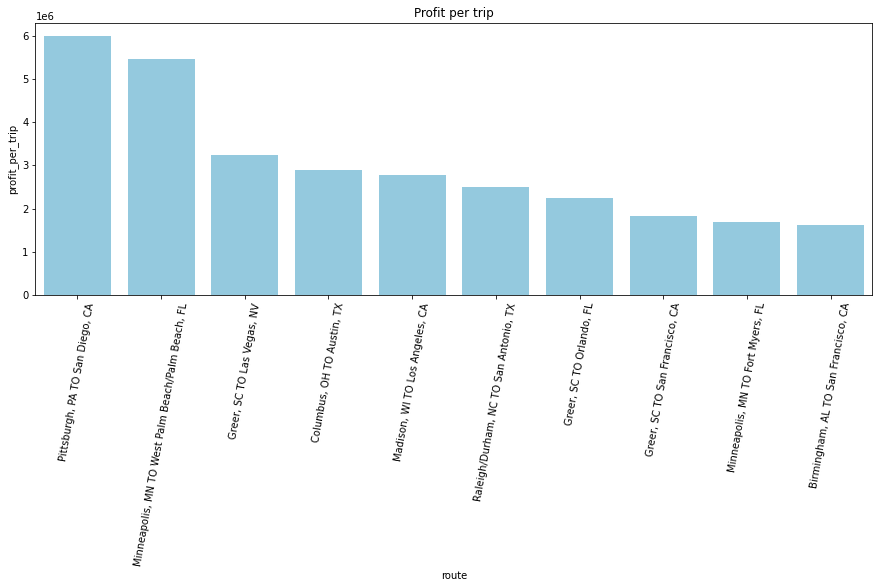

In [29]:
# Calculate profit of one single round trip of a route since busiest route might generate more income
# Per trip profit is equal to profit devided by total flights in that route
df['profit_per_trip'] = df['profit']/df['total_count']
tmp = df.sort_values(by = 'profit_per_trip',ascending = False)[:10]
plt.title('Profit per trip')
ax = sns.barplot(x = tmp['route'],y = tmp['profit_per_trip'], color='skyblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 80)

It is a vague outcome, we observed count of total flights. Unfortunately, due to low number of flights in considered routes, we can not have proper evaluation. As a result, we should consider busy airports since our goal is to increase revenue and customers. Moving forward, let us find out the busy airports and add as new column.

In [30]:
# get the busy airports with following details and assumptions
## Considerations for calculation
    # number of planes = 5
    # Per quarter total routes count is approximately ninty days with consideration of plane mainainace days
    # Hence, per month fly count is 450 (ie. 90*5). To consider profit, add up the value by 20%.
    # Assuming the all airports are busy if totals are more than 600.

df['busy_route'] = np.where((df['total_count'] >= 600),1,0)

### Total Profit for busy routes on per round trip

[Text(0, 0, 'Minneapolis, MN TO Orlando, FL'),
 Text(1, 0, 'New York, NY TO Los Angeles, CA'),
 Text(2, 0, 'New York, NY TO Las Vegas, NV'),
 Text(3, 0, 'Newark, NJ TO San Francisco, CA'),
 Text(4, 0, 'Newark, NJ TO Los Angeles, CA'),
 Text(5, 0, 'Minneapolis, MN TO Phoenix, AZ'),
 Text(6, 0, 'Minneapolis, MN TO Las Vegas, NV'),
 Text(7, 0, 'New York, NY TO San Francisco, CA'),
 Text(8, 0, 'Detroit, MI TO Fort Lauderdale, FL'),
 Text(9, 0, 'Boston, MA TO Orlando, FL')]

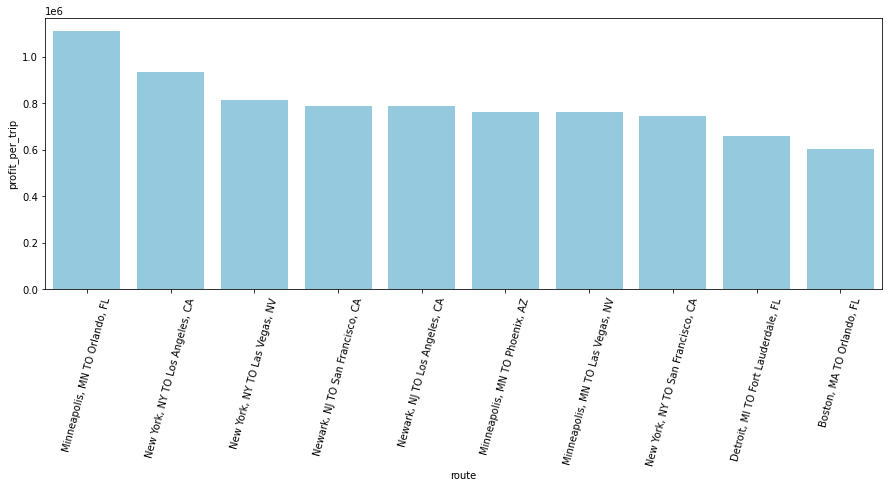

In [31]:
tmp = df[df['busy_route'] == 1]
tmp = tmp.sort_values(by = 'profit_per_trip', ascending = False)[:10]
ax = sns.barplot(x = tmp['route'], y = tmp['profit_per_trip'], color='skyblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 75)

### Least delay flights in busy routes

[Text(0, 0, 'Honolulu, HI TO Kona, HI'),
 Text(1, 0, 'Atlanta, GA TO Norfolk, VA'),
 Text(2, 0, 'Honolulu, HI TO Hilo, HI'),
 Text(3, 0, 'Salt Lake City, UT TO Portland, OR'),
 Text(4, 0, 'Honolulu, HI TO Lihue, HI'),
 Text(5, 0, 'Charleston, SC TO Atlanta, GA'),
 Text(6, 0, 'Boise, ID TO Portland, OR'),
 Text(7, 0, 'Atlanta, GA TO Greensboro/High Point, NC'),
 Text(8, 0, 'Atlanta, GA TO Salt Lake City, UT'),
 Text(9, 0, 'Portland, OR TO Boise, ID')]

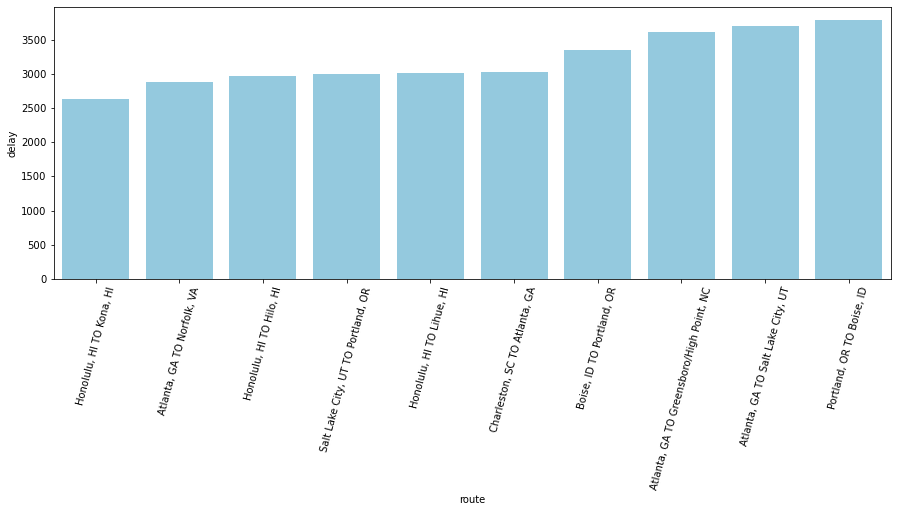

In [32]:
df['delay'] = df['DEP_DELAY'] + df['ARR_DELAY'] 
tmp = df[df['busy_route'] == 1]
tmp = tmp.sort_values(by = 'delay', ascending = True)[:10]
ax = sns.barplot(x = tmp['route'], y = tmp['delay'], color='skyblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 75)

## 3. The 5 round trip routes that I recommend to invest:

In [33]:
# develop a score metric with consideration of minimum delay, customer growth along with profit
from sklearn import preprocessing
# total flight count and it's delay metric would be considered from 0 to 1
min_max_scaler = preprocessing.MinMaxScaler()
tmp = df[df['busy_route'] == 1]
x_scaled = min_max_scaler.fit_transform(tmp[['delay','profit_per_trip','total_count']])
tmp['delay'] = x_scaled[:,0].tolist()
tmp['delay'] = 1 - tmp['delay'] 
# In score metric, our weightage on profit is 33 percent; 33 for flights count; and 33 for delay
tmp['profit_per_trip'] = x_scaled[:,1].tolist()
tmp['total_count'] = x_scaled[:,2].tolist()
tmp['score'] = 0.33 * tmp['delay'] + 0.33 * tmp['profit_per_trip'] + 0.33 * tmp['total_count']

[Text(0, 0, 'New York, NY TO Los Angeles, CA'),
 Text(1, 0, 'Minneapolis, MN TO Orlando, FL'),
 Text(2, 0, 'New York, NY TO Las Vegas, NV'),
 Text(3, 0, 'Los Angeles, CA TO New York, NY'),
 Text(4, 0, 'Minneapolis, MN TO Phoenix, AZ')]

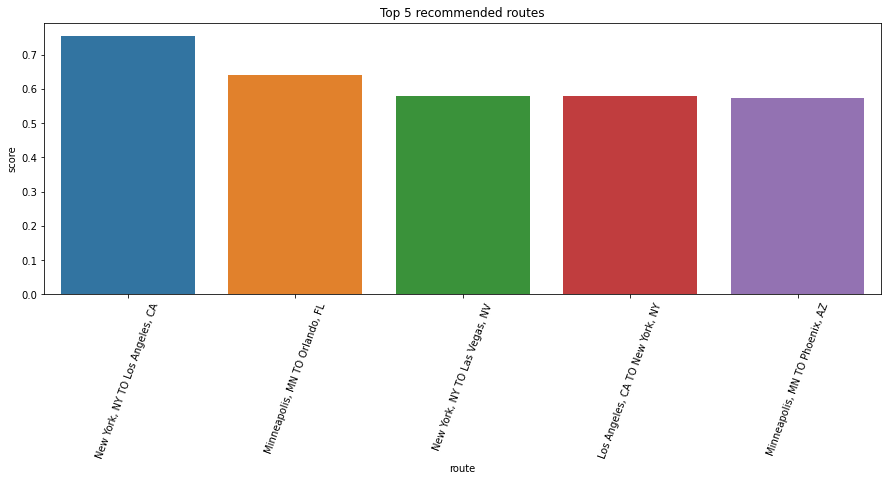

In [34]:
# Bar plot Visualization of best routes for investment purposes
tmp=tmp.sort_values(by='score',ascending=False)[:5]
ax=sns.barplot(x=tmp['route'],y=tmp['score'])
plt.title('Top 5 recommended routes')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 70)

# Top 5 round trip routes are as follows:
    # New York, NY to Los Angeles, CA 
    # Minneapolis, MN to Orlando, FL 
    # New York, NY to Las Vegas, NV 
    # Los Angeles, CA to New York, NY 
    # Minneapolis, MN to Phoenix, AZ 

## 4. Required number of trips for breakeven on the upfront airplane cost:

For all 5 recommended routes-

**First round trip route** New York,NY to Los Angeles,CA
     **Avg. profit** 940,509.4878
     **Required trips count** 96 (~95.69281455)

**Second round trip route** Minnepolis, MN to Orlando, FL
     **Avg. profit** 1,117,163.743
     **Required trips count** 81 (~80.56115373)

**Third round trip route** New York, NY to Las Vegas, NV 
     **Avg. profit** 819,852.2287
     **Required trips count** 110 (~109.7758801)
     
**Fourth round trip route** Los Angeles, CA to New York, NY
     **Avg. profit** 467619.4666
     **Required trips count** 193 (~192.464186)
     
**Fifth round trip route** Minnepolis, MN to Pheonix, AZ 
     **Avg. profit** 766,488.7265
     **Required trips count** 118 (~117.4185567)

## 5. Recommended Key Performance Indicators:

**A.** Details regarding flight ticket promotions; frequent flyers vs. new users; specific credit card users for discounts such as miles reward.</br>
**B.** Our scoring metric could vary based on targeted travelers by individual airline companies.</br>
**C.** Cost of living and average income of the cities. Also, basic cost along with variables such as tax, compliance, government involvement in tourism etc. depending on these cities.</br>
**D.** Data regarding seat counts in planes and their class distributions such as first, business, and economy.</br>
**E.** Regular busy airport (junction) vs. seasonal busy (tourist destination) airports due to tourism or factors like major events/festivals.</br>
**F.** Number of other competitive existing airlines for these routes.</br>
**G.** Flight schedule changes and its frequency.</br>
**H.** Additional hidden income and expenditure generated; eg. income via onboard services such as WiFi, food etc. & expenditure such as contingent aircraft maintenance.</br>
**I.** Average weather data of these routes might be helpful in terms of knowing flight cancellation cost due to bad weather.</br>
